Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [20]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (423260, 28, 28) (423260,)
Validation set (105820, 28, 28) (105820,)
Test set (18724, 28, 28) (18724,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (423260, 784) (423260, 10)
Validation set (105820, 784) (105820, 10)
Test set (18724, 784) (18724, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

# L2 regularization (beta = 0.1)

$$\mathcal{L}^{\prime} = \mathcal{L} + \beta \frac{1}{2} {|| w ||}_{2}^{2}$$
Where $\mathcal{L}$ is the new computed loss with l2 regularization and $\beta$ is the parameter

# 1. Logistic regression with l2 ($\beta = 0.1$)

In [ ]:
train_subset = 10000
beta = 0.1
graph = tf.Graph()

with graph.as_default():

    # Load the training, validation and test data
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # the softmax and cross-entropy . We take the average of this
    # cross-entropy across all training examples (the loss)
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    #Add l2 regularization
    loss = tf.reduce_mean(loss + beta*tf.nn.l2_loss(weights))
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
num_steps = 801

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(
            predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run()
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# 2. Logistic regression with SGD with l2 ($\beta = 0.1$)

In [ ]:
batch_size = 128
beta = 0.1

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    #Add l2 regularization
    loss = tf.reduce_mean(loss + beta*tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

# 3. Neural network with l2 ($\beta = 0.01$)

In [ ]:
batch_size = 128
beta = 0.01

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #Hiddel layer
    hidden_nodes = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    #Initialize the weights
    weights = tf.Variable(
            tf.truncated_normal([hidden_nodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # We compute the softmax and cross-entropy and the average of cross entropy (loss)
    logits = tf.matmul(hidden_layer, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Add l2 regularization
    loss = tf.reduce_mean(loss + beta * tf.nn.l2_loss(weights))
    
    # Optimizer using gradient descent
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_relu, weights) + biases)
    
    test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights) + biases)

In [ ]:
num_steps = 4001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

# Logistic model model with l2 ($\beta = 0.1$) and small training data

In [ ]:
batch_size = 128
beta = 0.1

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
    #Add l2 regularization
    loss = tf.reduce_mean(loss + beta*tf.nn.l2_loss(weights))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [ ]:
num_steps = 3001

max_training_batch = 200
train_dataset_2 = train_dataset[:max_training_batch, :]
train_labels_2 = train_labels[:max_training_batch]

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels_2.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset_2[offset:(offset + batch_size), :]
        batch_labels = train_labels_2[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print(offset)
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [ ]:
batch_size = 128
beta = 0.001

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    #Hiddel layer
    hidden_nodes = 1024
    hidden_weights = tf.Variable(tf.truncated_normal([image_size*image_size, hidden_nodes]))
    hidden_biases = tf.Variable(tf.zeros([hidden_nodes]))
    hidden_layer = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
    
    # Add dropout
    keep_prob = tf.placeholder("float")
    hidden_layer_dropout = tf.nn.dropout(hidden_layer, keep_prob=keep_prob)
    
    #Initialize the weights
    weights = tf.Variable(
            tf.truncated_normal([hidden_nodes, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # We compute the softmax and cross-entropy and the average of cross entropy (loss)
    logits = tf.matmul(hidden_layer, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Add l2 regularization
    loss = tf.reduce_mean(loss + beta * tf.nn.l2_loss(weights))
    
    # Optimizer using gradient descent
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_relu, weights) + biases)
    
    test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
    test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights) + biases)

In [ ]:
num_steps = 4001

# Dropout probability
keep_probability = 0.5

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : keep_probability}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


# Neural network with 3 hidden layers, l2 regularization and dropout

In [39]:
def plot_acc(x, labels):
    fig = plt.figure()
    #fig.add_subplot(121)
    for data, label in zip(x, labels):
        plt.plot(data, label = label)
    plt.legend()
    plt.show()

In [41]:
batch_size = 128
beta = 0.001
#l_rate = 0.1

h_nodes_1 = 1024
h_nodes_2 = 512
h_nodes_3 = 256

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Hidden layer1
    h_weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size, h_nodes_1]))
    h_biases_1 = tf.Variable(tf.zeros([h_nodes_1]))
    h_layer_1 = tf.nn.relu(tf.matmul(tf_train_dataset, h_weights_1) + h_biases_1)
    
    # Add dropout to hidden layer 1
    keep_prob = tf.placeholder("float")
    h_layer_dropout_1 = tf.nn.dropout(h_layer_1, keep_prob=keep_prob)
    
    # Hidden layer 2
    h_weights_2 = tf.Variable(tf.truncated_normal([h_nodes_1, h_nodes_2]))
    h_biases_2 = tf.Variable(tf.zeros([h_nodes_2]))
    h_layer_2 = tf.nn.relu(tf.matmul(h_layer_dropout_1, h_weights_2) + h_biases_2)
    
    # Add dropout to hidden layer 2
    h_layer_dropout_2 = tf.nn.dropout(h_layer_2, keep_prob=keep_prob)
    
    # Hidden layer 3
    #h_weights_3 = tf.Variable(tf.truncated_normal([h_nodes_2, h_nodes_3]))
    #h_biases_3 = tf.Variable(tf.zeros([h_nodes_3]))
    #h_layer_3 = tf.nn.relu(tf.matmul(h_layer_dropout_2, h_weights_3) + h_biases_3)
    
    # Add dropout to hidden layer 3
    #h_layer_dropout_3 = tf.nn.dropout(h_layer_3, keep_prob=keep_prob)
    
    #Initialize the weights
    weights = tf.Variable(
            tf.truncated_normal([h_nodes_2, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # We compute the softmax and cross-entropy and the average of cross entropy (loss)
    logits = tf.matmul(h_layer_dropout_2, weights) + biases
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
    # Add l2 regularization
    loss = tf.reduce_mean(loss + beta * tf.nn.l2_loss(weights))
    
    # Optimizer using gradient descent
    global_step = tf.Variable(0)  
    l_rate = tf.placeholder("float")
    learning_rate = tf.train.exponential_decay(l_rate, global_step, 10000, 0.95, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step= global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    valid_relu_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, h_weights_1) + h_biases_1)
    valid_relu_2 = tf.nn.relu(tf.matmul(valid_relu_1, h_weights_2) + h_biases_2)
    #valid_relu_3 = tf.nn.relu(tf.matmul(valid_relu_2, h_weights_3) + h_biases_3)    
    valid_prediction = tf.nn.softmax(tf.matmul(valid_relu_2, weights) + biases)
    
    test_relu_1 = tf.nn.relu(tf.matmul(tf_test_dataset, h_weights_1) + h_biases_1)
    test_relu_2 = tf.nn.relu(tf.matmul(test_relu_1, h_weights_2) + h_biases_2)
    #test_relu_3 = tf.nn.relu(tf.matmul(test_relu_2, h_weights_3) + h_biases_3)
    
    test_prediction = tf.nn.softmax(tf.matmul(test_relu_2, weights) + biases)

Initialized
Minibatch loss at step 0: 8993.262695
Minibatch loss at step 500: 902.607910
Minibatch loss at step 1000: 363.971100
Minibatch loss at step 1500: 299.781372
Minibatch loss at step 2000: 229.966934
Minibatch loss at step 2500: 195.815155
Minibatch loss at step 3000: 105.357628
Minibatch loss at step 3500: 56.329926
Minibatch loss at step 4000: 72.645767


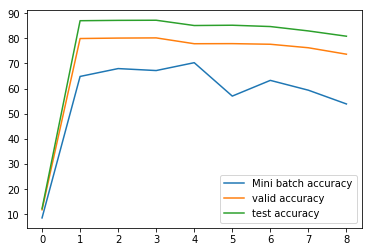

In [43]:
num_steps = 4001

# Dropout probability
keep_probability = 0.45

learning_rate = 0.001

mini_batch_loss_list = []
mini_batch_acc = []
valid_acc = []
test_acc = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, 
                     keep_prob : keep_probability, l_rate : learning_rate}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            #print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
            mini_batch_acc.append(accuracy(predictions, batch_labels))
            valid_acc.append(accuracy(valid_prediction.eval(), valid_labels))
            test_acc.append(accuracy(test_prediction.eval(), test_labels))

plot_acc([mini_batch_acc, valid_acc, test_acc], ['Mini batch accuracy', 'valid accuracy', 'test accuracy'])